In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import networkx as nx

In [2]:
lsa = pd.read_pickle('lsa_courses.pkl')
eng = pd.read_pickle('eng_courses.pkl')

#Removing 
stop_words = set(stopwords.words('english'))
exclude = set(["course", 'students'])

def clean_description(text):
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    cleaned_tokens = [word for word in cleaned_tokens if word.lower() not in exclude and word.isalpha()]
    return ' '.join(cleaned_tokens)

lsa['cleaned_description'] = lsa['description_x'].apply(clean_description)
eng['cleaned_description'] = eng['description_x'].apply(clean_description)
lsa['cleaned_description'] = lsa['cleaned_description'].str.lower()
eng['cleaned_description'] = eng['cleaned_description'].str.lower()

# Originally used 100 most common, behavior became much 'better' when increased to 500

#This gets the top n most common words in descriptions acrossLSA and ENG
combined_df = pd.concat([lsa, eng], ignore_index=True)
all_words = ' '.join(combined_df['cleaned_description']).split()
word_freq = Counter(all_words)
top_words = [word for word, freq in word_freq.most_common(500)]


#Function to vectorize description beased on previous basis
def vectorize_description(text):
    tokens = text.split()
    vector = [1 if word in tokens else 0 for word in top_words]
    return vector

def vectorize_description_scaled(text):
    word_counts = Counter(text.split())
    # Create a vector where each element is the frequency of a word in the basis_of_words
    vector = [word_counts[word] if word in word_counts else 0 for word in top_words]
    return vector

# Takes in two course names, the name of the column that holds the names, the dataframe, and the similarity matrix
# and returns their cosine similarity
def get_similarity(name1, name2, type, df, matrix):
    idx_1 = df[df[type] == name1].index
    idx_1 = idx_1[0]
    idx_2 = df[df[type] == name2].index
    idx_2 = idx_2[0]
    return matrix[idx_1, idx_2]

# Gets the course's cleaned description that is used to vectorize it
def get_clean_desc(name):
    idx_1 = concatenated_descriptions[concatenated_descriptions['department'] == name].index
    idx_1 = idx_1[0]
    return concatenated_descriptions.iloc[idx_1]['cleaned_description']

# Gets the course's regular description that is used to vectorize it
def get_reg_desc(name):
    idx_1 = combined_df[combined_df['course'] == name].index
    idx_1 = idx_1[0]
    return combined_df.iloc[idx_1]['description_x']

concatenated_descriptions = combined_df.groupby('department')['description_x'].apply(' '.join).reset_index()
concatenated_descriptions['cleaned_description'] = concatenated_descriptions['description_x'].apply(clean_description)
concatenated_descriptions['cleaned_description'] = concatenated_descriptions['cleaned_description'].str.lower()

all_words = ' '.join(concatenated_descriptions['cleaned_description']).split()
word_freq = Counter(all_words)
top_words = [word for word, freq in word_freq.most_common(500)]
# Generate words
concatenated_descriptions['vector'] = concatenated_descriptions['cleaned_description'].apply(vectorize_description_scaled)

#Generate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

def course_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Make similarity matrix
matrix = [vec for vec in concatenated_descriptions['vector']]
# Compute cosine similarities
similarity_matrix = cosine_similarity(matrix)
#Find similar courses
deps = concatenated_descriptions['department'].tolist()

In [3]:
def common_words(str1, str2, n):
    # Splitting the strings into words
    words_str1 = str1.split()
    words_str2 = str2.split()

    # Creating a dictionary to count the occurrences of each word in both strings
    word_count = {}
    for word in words_str1:
        if word in words_str2:
            word_count[word] = min(words_str1.count(word), words_str2.count(word))

    # Sorting the dictionary by the frequency of the words
    sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

    return sorted_word_count[0:n]

In [4]:
def get_related(name, df, matrix, n):
    n=n+1
    idx = df[df['department'] == name].index
    sims = matrix[idx]
    # Get indices of sorted elements
    sorted_indices = np.argsort(sims)
    # Get indices of top n largest elements
    top_n_indices = sorted_indices[0][-n:][::-1]
    top_n_deps = np.array(deps)[top_n_indices]
    top_n_deps = np.delete(top_n_deps, np.where(top_n_deps == name))
    return top_n_deps

In [8]:
def get_threshold(matrix, max_pairs):
    """
    Find the threshold for similarity scores in the matrix.

    :param matrix: A 2D numpy array containing similarity scores between classes.
    :param max_pairs: Maximum number of class pairs with similarity above the threshold.
    :return: Threshold value.
    """

    # Flatten the matrix to get all similarity scores
    scores = matrix[np.triu_indices_from(matrix, k=1)]  # k=1 to exclude the diagonal

    # Create bins for the range [0, 1]
    num_bins = 100
    bins = np.linspace(0, 1, num_bins + 1)
    
    # Count the number of scores in each bin
    counts, _ = np.histogram(scores, bins)

    # Find the cumulative count
    cumulative_counts = np.cumsum(counts[::-1])[::-1]

    # Find the bin where the cumulative count drops below the max_pairs
    threshold_index = np.where(cumulative_counts <= max_pairs)[0]

    if len(threshold_index) == 0:
        return 1  # Return 1 if no such threshold exists (i.e., all scores are too low)

    # Get the lower edge of the bin as the threshold
    threshold_bin = threshold_index[0]
    threshold = bins[threshold_bin]

    return threshold

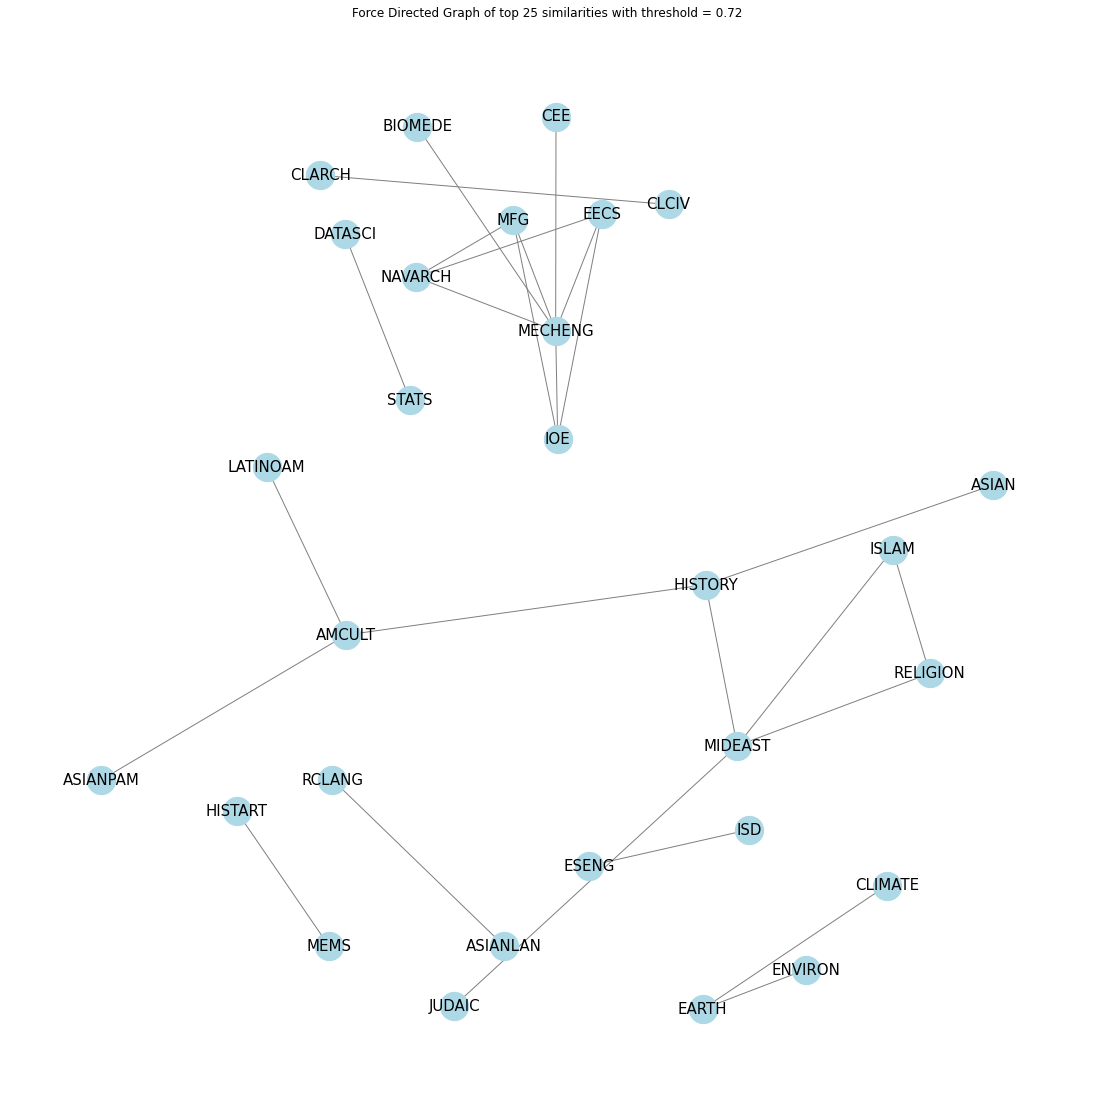

In [11]:
# Example adjacency matrix (replace this with your actual matrix)
# Assuming a 5x5 matrix for demonstration
adjacency_matrix = similarity_matrix

# Create a graph
G = nx.Graph()

threshold = get_threshold(similarity_matrix, 25)

course_indices = set()
# Adding nodes and edges based on the adjacency matrix
for i in range(len(adjacency_matrix)):
    for j in range(i+1, len(adjacency_matrix)):
        # Add an edge between i and j with weight based on cosine similarity
        if similarity_matrix[i][j] > threshold:
            course_indices.add(i)
            course_indices.add(j)
            G.add_edge(deps[i], deps[j], weight=similarity_matrix[i][j])

# Generate positions for the nodes using a force-directed algorithm
positions = nx.spring_layout(G, weight='weight', k=0.7)

# Draw the graph
plt.figure(figsize=(15, 15))
nx.draw(G, positions, with_labels=True, node_color='lightblue', 
        node_size=800, edge_color='gray', linewidths=1, font_size=15)
plt.title(f"Force Directed Graph of top 25 similarities with threshold = {threshold}")
plt.show()


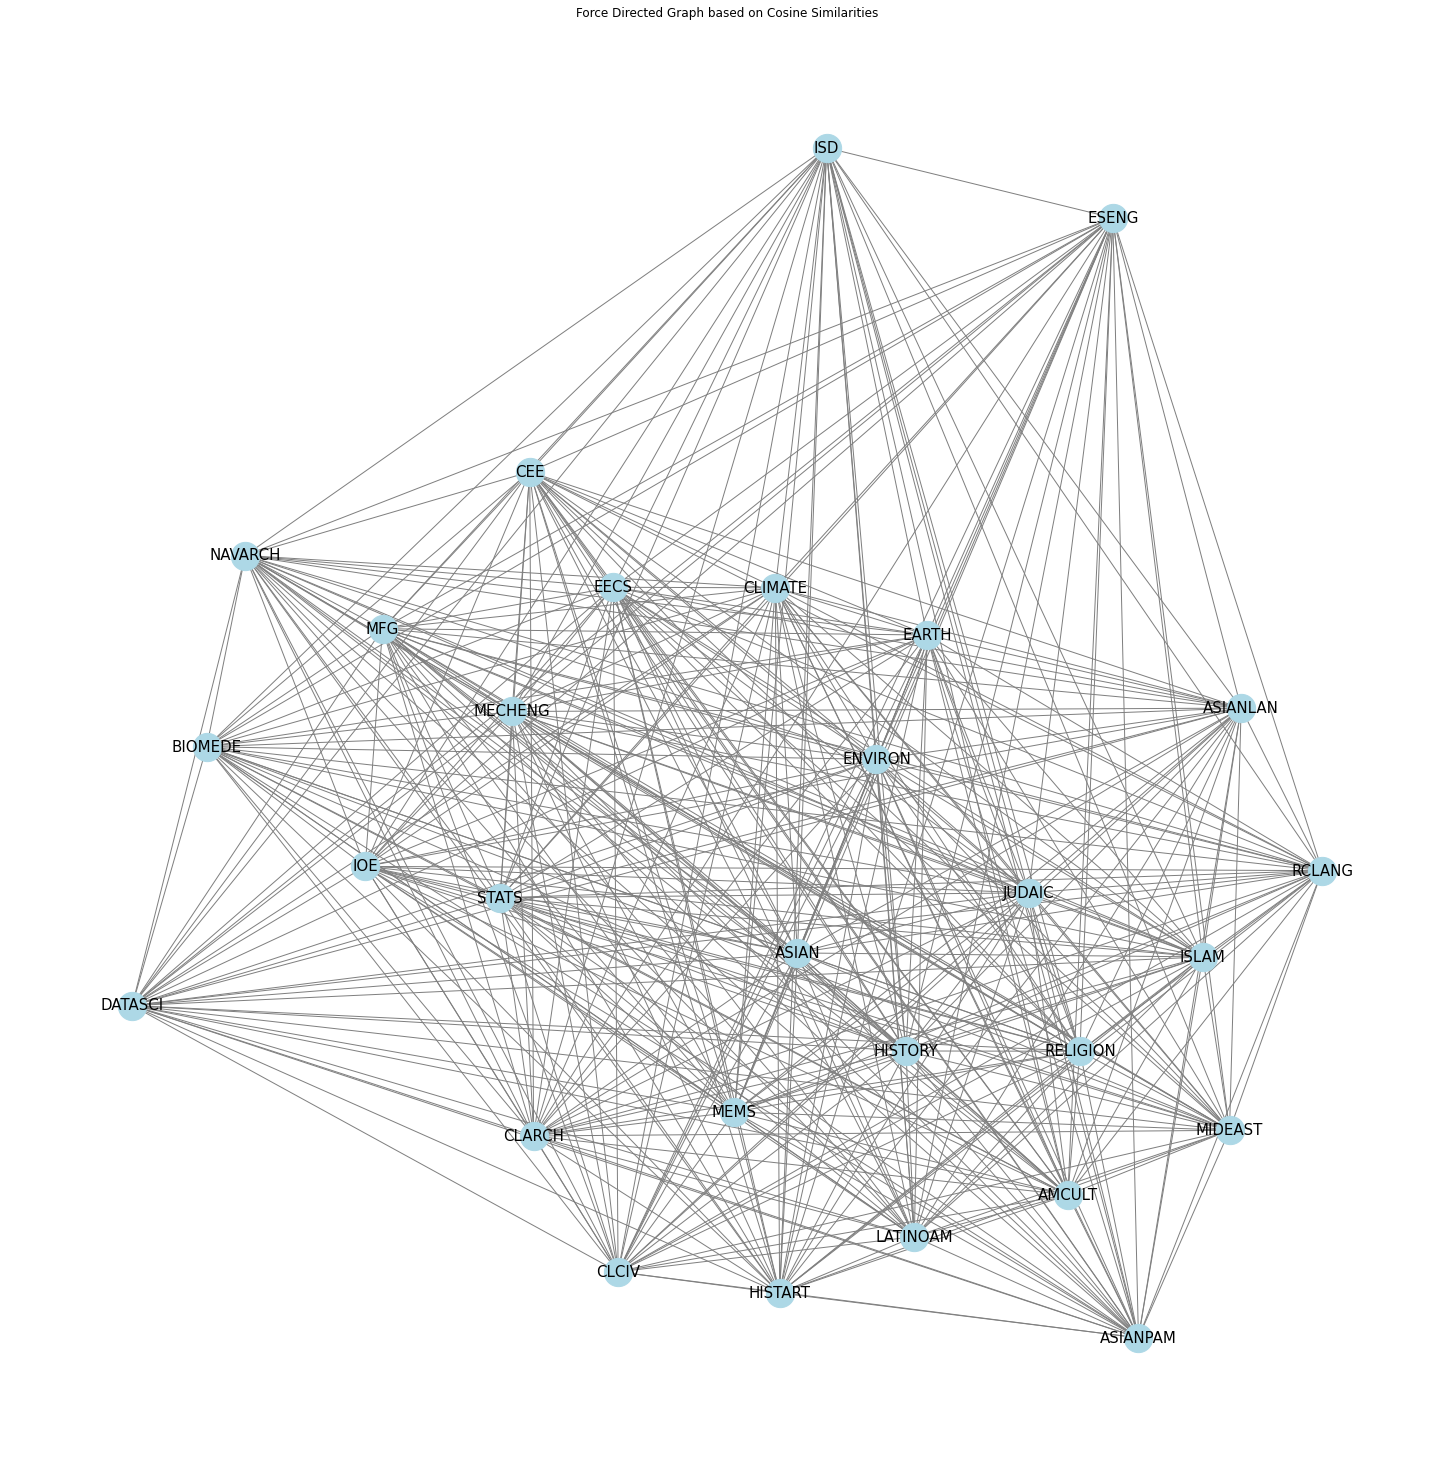

In [30]:
# Example adjacency matrix (replace this with your actual matrix)
# Assuming a 5x5 matrix for demonstration
adjacency_matrix = similarity_matrix

# Create a graph
G = nx.Graph()

# Adding nodes and edges based on the adjacency matrix
for i in range(len(adjacency_matrix)):
    for j in range(i+1, len(adjacency_matrix)):
        # Add an edge between i and j with weight based on cosine similarity
        if i in course_indices and j in course_indices:
            G.add_edge(deps[i], deps[j], weight=similarity_matrix[i][j])

# Generate positions for the nodes using a force-directed algorithm
positions = nx.spring_layout(G, weight='weight', k=0.7)

# Draw the graph
plt.figure(figsize=(20, 20))
nx.draw(G, positions, with_labels=True, node_color='lightblue', 
        node_size=800, edge_color='gray', linewidths=1, font_size=15)
plt.title("Force Directed Graph based on Cosine Similarities")
plt.show()

### Top 10 related deps for ENVIRON

In [26]:
def dep_sim_analysis(dep_name):
    related_departments = get_related('ENVIRON', concatenated_descriptions, similarity_matrix, 10)
    word_df = pd.DataFrame()
    for dept in related_departments:
        word_df[dept] = common_words(get_clean_desc('ENVIRON'), get_clean_desc(dept), 10)
    return word_df

In [47]:
related_departments = get_related('ENVIRON', concatenated_descriptions, similarity_matrix, 10)
word_df = pd.DataFrame()
for dept in related_departments:
    word_df[dept] = common_words(get_clean_desc('ENVIRON'), get_clean_desc(dept), 10)
word_df

,EARTH,STS,GEOG,CLIMATE,RCIDIV,EEB,SOC,ORGSTUDY,POLSCI,BIOLOGY
0,"(energy, 34)","(health, 14)","(global, 11)","(earth, 14)","(environmental, 9)","(field, 24)","(social, 29)","(research, 12)","(social, 20)","(human, 8)"
1,"(climate, 33)","(history, 11)","(human, 10)","(systems, 13)","(social, 6)","(ecology, 23)","(issues, 24)","(social, 11)","(topics, 20)","(systems, 8)"
2,"(global, 26)","(human, 9)","(change, 9)","(energy, 11)","(justice, 5)","(research, 13)","(human, 20)","(human, 7)","(world, 17)","(biological, 8)"
3,"(change, 23)","(environmental, 8)","(resources, 5)","(global, 10)","(change, 4)","(study, 12)","(class, 18)","(different, 6)","(science, 16)","(science, 7)"
4,"(earth, 23)","(social, 7)","(ii, 4)","(human, 10)","(sustainability, 4)","(understanding, 11)","(examine, 15)","(environment, 6)","(environmental, 15)","(animals, 7)"
5,"(environmental, 21)","(environment, 7)","(environmental, 3)","(change, 10)","(environment, 3)","(ecosystems, 11)","(change, 14)","(environmental, 5)","(public, 15)","(health, 7)"
6,"(natural, 21)","(public, 7)","(energy, 3)","(climate, 9)","(people, 3)","(including, 11)","(political, 14)","(natural, 5)","(also, 14)","(understanding, 6)"
7,"(world, 20)","(explore, 6)","(climate, 3)","(analysis, 7)","(lectures, 3)","(ecological, 11)","(research, 13)","(understanding, 4)","(political, 14)","(topics, 6)"
8,"(systems, 19)","(nature, 6)","(population, 3)","(introduction, 7)","(globalization, 3)","(michigan, 10)","(explore, 12)","(studies, 4)","(introduction, 11)","(food, 5)"
9,"(science, 17)","(also, 6)","(future, 3)","(processes, 7)","(issues, 2)","(include, 10)","(study, 12)","(economic, 4)","(one, 11)","(basic, 5)"


In [52]:
related_departments = get_related('ENGLISH', concatenated_descriptions, similarity_matrix, 5)
word_df = pd.DataFrame()
for dept in related_departments:
    word_df[dept] = common_words(get_clean_desc('ENGLISH'), get_clean_desc(dept), 10)
word_df

,RCHUMS,COMPLIT,AAS,AMCULT,HISTORY
0,"(works, 18)","(literature, 19)","(american, 29)","(american, 34)","(american, 34)"
1,"(work, 16)","(literary, 18)","(writing, 22)","(also, 22)","(study, 31)"
2,"(century, 16)","(texts, 9)","(history, 18)","(century, 19)","(also, 25)"
3,"(political, 15)","(critical, 7)","(also, 18)","(history, 18)","(well, 21)"
4,"(class, 14)","(study, 6)","(social, 18)","(social, 18)","(century, 19)"
5,"(one, 12)","(historical, 6)","(world, 18)","(political, 17)","(world, 19)"
6,"(social, 12)","(writing, 6)","(political, 17)","(explore, 15)","(one, 18)"
7,"(history, 10)","(world, 6)","(literature, 14)","(culture, 15)","(history, 18)"
8,"(plays, 10)","(different, 5)","(class, 14)","(questions, 14)","(social, 18)"
9,"(major, 10)","(history, 5)","(african, 13)","(class, 14)","(new, 18)"


In [35]:
concatenated_descriptions["department"]

0           AAS
1        AEROSP
2           ALA
3          AMAS
4        AMCULT
         ...   
120         UKR
121         WGS
122    WOMENSTD
123     WRITING
124     YIDDISH
Name: department, Length: 125, dtype: object

In [61]:
env_hist_common = common_words(get_clean_desc('ENVIRON'), get_clean_desc('HISTORY'), 5)

In [62]:
env_hist_common

[('course', 126),
 ('students', 49),
 ('social', 29),
 ('also', 25),
 ('history', 24)]

## STEM DEPARTMENTS

In [13]:
stem = set(["AEROSP", "EECS", "MATH", "PHYSICS", "STATS", "ENGR", "ASTRO", "CEE", "MECHENG", "DATASCI", "BIOMEDE", "BIOPHYS", "SPACE", "CHEM", "BIOPHYS", "CMPLXSYS"])

In [14]:
mask = concatenated_descriptions["department"].isin(stem)
stem_deps = concatenated_descriptions[mask]

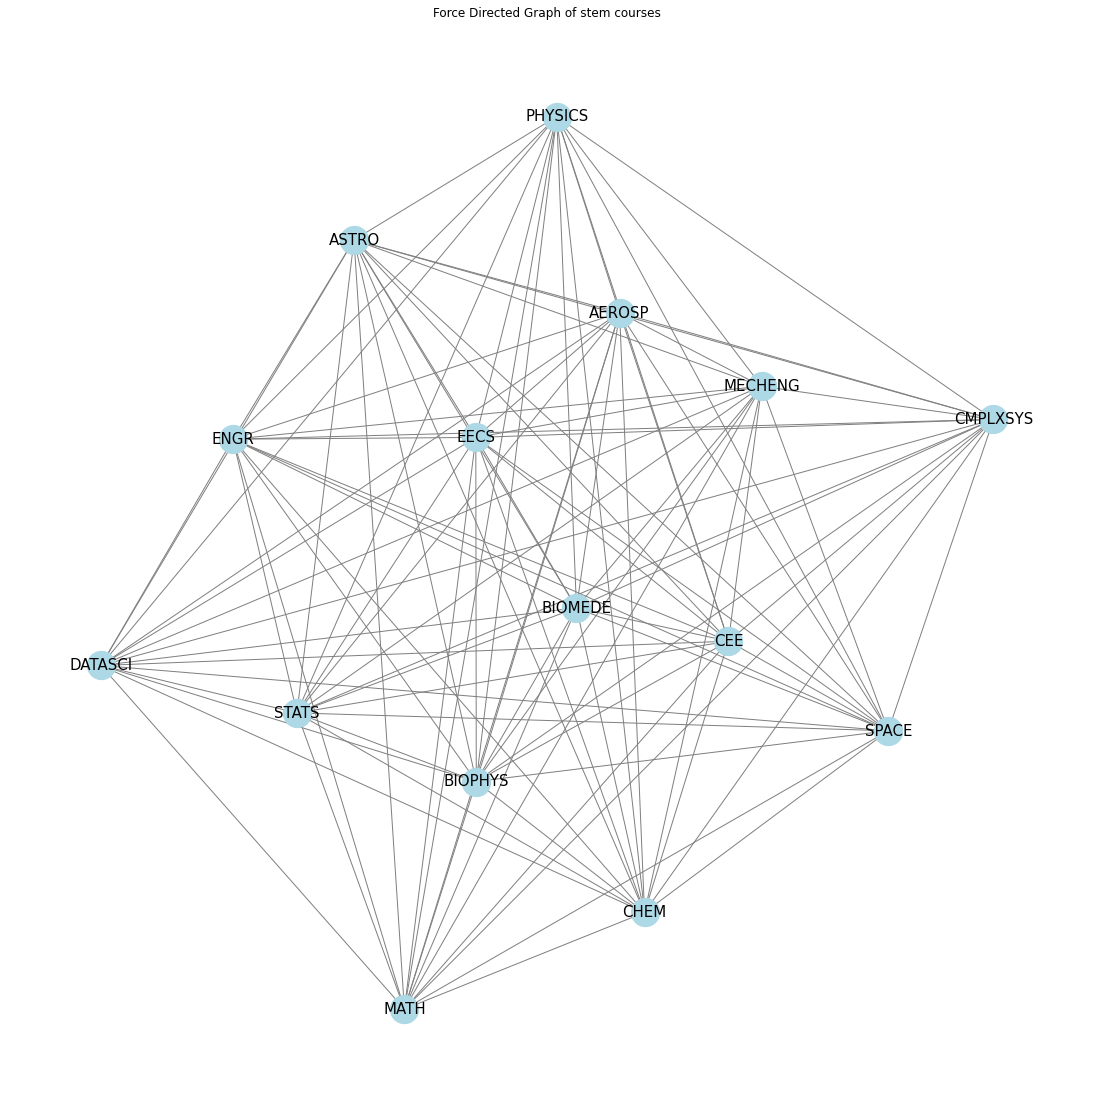

In [15]:
mask = concatenated_descriptions["department"].isin(stem)
stem_deps = concatenated_descriptions[mask]
# Make similarity matrix
matrix = [vec for vec in stem_deps['vector']]
# Compute cosine similarities
similarity_matrix = cosine_similarity(matrix)
#Find similar courses
deps = stem_deps['department'].tolist()

# Example adjacency matrix (replace this with your actual matrix)
# Assuming a 5x5 matrix for demonstration
adjacency_matrix = similarity_matrix

# Create a graph
G = nx.Graph()

threshold = get_threshold(similarity_matrix, 25)

course_indices = set()
# Adding nodes and edges based on the adjacency matrix
for i in range(len(adjacency_matrix)):
    for j in range(i+1, len(adjacency_matrix)):
        # Add an edge between i and j with weight based on cosine similarity
        #if similarity_matrix[i][j] > threshold:
        course_indices.add(i)
        course_indices.add(j)
        G.add_edge(deps[i], deps[j], weight=similarity_matrix[i][j])

# Generate positions for the nodes using a force-directed algorithm
positions = nx.spring_layout(G, weight='weight', k=0.7)

# Draw the graph
plt.figure(figsize=(15, 15))
nx.draw(G, positions, with_labels=True, node_color='lightblue', 
        node_size=800, edge_color='gray', linewidths=1, font_size=15)
plt.title(f"Force Directed Graph of stem courses")
plt.show()